In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..")
using SatelliteTasking
using SatelliteTasking.Analysis

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1

# Define Satellite Orbit
oe   = [R_EARTH + 500e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Numer of perturbed orbits to simulate
num_orbits = 100

# Set Perturbation Values 
pos_error = 5000 # Position knowledge error [m]
vel_error = 5    # Velocity knowledge error [m/s]
orb_mean  = zeros(Float64, 6)
orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

# Simulate true and perturbed orbits
@time true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep);

312.347054 seconds (2.92 G allocations: 122.830 GiB, 14.43% gc time)


In [3]:
# Compute True and perturbed collects

# Load test images
@time images = load_images("../data/landsat_test.json");

@time true_collects, perturbed_collects, mean_diff, sdev_diff, missing_collects  = compute_perturbed_collects(true_orbit, perturbed_orbits, images, epc_step=3600);

  0.261995 seconds (670.26 k allocations: 35.216 MiB, 5.46% gc time)
1275.686672 seconds (17.02 G allocations: 1.754 TiB, 17.47% gc time)


In [4]:
# println(hcat(mean_diff...))
println(sdev_diff[1,:])
println(sdev_diff[2,:])
println(sdev_diff[3,:])
println(missing_collects)

[27.8615, 3.3705, 24.6318, 16.1988, 24.1853, 30.1463, 1.9518, 35.6583, 24.9398, 41.9295, 30.9432, 61.0804, 21.9024, 31.9332, 82.1743, 50.7948, 52.138, 97.5038, 54.6972, 39.6695, 31.0753, 61.6752, 105.311, 25.8362]
[28.3912, 8.83343, 22.8931, 8.73308, 22.4536, 25.8559, 5.35413, 32.5217, 19.5619, 45.9736, 32.1276, 50.6563, 21.3287, 36.869, 56.7304, 53.0337, 53.5399, 100.054, 49.1967, 45.108, 41.5938, 53.2013, 89.7433, 28.9988]
[3.41454, 6.27964, 9.83161, 12.801, 6.95212, 11.8618, 5.20988, 13.4133, 11.4395, 21.0881, 24.837, 43.6268, 11.296, 37.5365, 53.3131, 22.1475, 32.8566, 28.0834, 22.9456, 42.9393, 32.8074, 34.5881, 22.5062, 29.6047]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


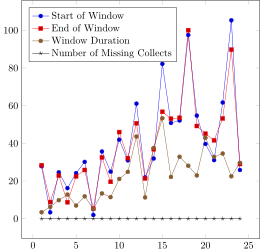

In [5]:
Axis([
    Plots.Linear(1:24, sdev_diff[1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff[2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff[3, :], legendentry="Window Duration")
    Plots.Linear(1:24, missing_collects, legendentry="Number of Missing Collects")
], width="10cm", height="10cm", legendPos="north west")